In [ ]:
# sentimental analysis of IMDB reviews using LSTM and GloVe embeddings

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Embedding
from keras.datasets import imdb
from keras import preprocessing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


In [43]:
import os

# raw file with reviews from https://www.kaggle.com/iarunava/imdb-movie-reviews-dataset
imdb_dir = './data/imdbraw/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf-8')
            try:
                texts.append(f.read())
            except:
                pass
            finally:
                f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [44]:
review_length = 200 # cuts off reviews after 200 words
training_samples = 20000 # trains on 20,000 samples
validation_samples = 5000 # validates on 5000 samples
max_words = 20000 # only top 20,000 words

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

print ('Found %s unique tokens.' % len(word_index))

# add padding up to review length
data = pad_sequences(sequences, maxlen=review_length)

labels = np.asarray(labels)
indices = np.arange(data.shape[0])

# shuffle and select training and validation sample
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]

x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88567 unique tokens.


In [49]:
print ('Shape of train X: %s' % (x_train.shape,))
print ('Shape of train Y: %s' % (y_train.shape,))
print ('Shape of validation X: %s' % (x_val.shape,))
print ('Shape of validation Y: %s' % (y_val.shape,))


Shape of train X: (20000, 200)
Shape of train Y: (20000,)
Shape of validation X: (4998, 200)
Shape of validation Y: (4998,)


In [51]:
# Load GloVe pretrained embeddings

embedding_dim = 100

glove_dir = './data/glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.'+str(embedding_dim)+'d.txt'), encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Word vectors: %s' % len(embeddings_index))
print('Embedding size: %s'% embedding_dim)

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Word vectors: 400000
Embedding size: 100


In [53]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, LSTM, Dropout

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=review_length))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [54]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 200, 100)          2000000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 2,117,377
Trainable params: 2,117,377
Non-trainable params: 0
_________________________________________________________________


In [55]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [56]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [58]:
history = model.fit(x_train, y_train, epochs=10, batch_size=batch_size, validation_data=(x_val, y_val))

Train on 20000 samples, validate on 4998 samples
Epoch 1/10
20000/20000 [==============================] - 360s 18ms/step - loss: 0.5670 - acc: 0.7096 - val_loss: 0.4578 - val_acc: 0.7929
Epoch 2/10
20000/20000 [==============================] - 358s 18ms/step - loss: 0.4367 - acc: 0.8056 - val_loss: 0.3890 - val_acc: 0.8277
Epoch 3/10
20000/20000 [==============================] - 359s 18ms/step - loss: 0.3718 - acc: 0.8383 - val_loss: 0.3371 - val_acc: 0.8577
Epoch 4/10
20000/20000 [==============================] - 358s 18ms/step - loss: 0.3354 - acc: 0.8569 - val_loss: 0.3396 - val_acc: 0.8513
Epoch 5/10
20000/20000 [==============================] - 358s 18ms/step - loss: 0.3079 - acc: 0.8735 - val_loss: 0.3103 - val_acc: 0.8695
Epoch 6/10
20000/20000 [==============================] - 358s 18ms/step - loss: 0.2830 - acc: 0.8813 - val_loss: 0.3042 - val_acc: 0.8717
Epoch 7/10
20000/20000 [==============================] - 358s 18ms/step - loss: 0.2565 - acc: 0.8942 - val_loss: 0.3

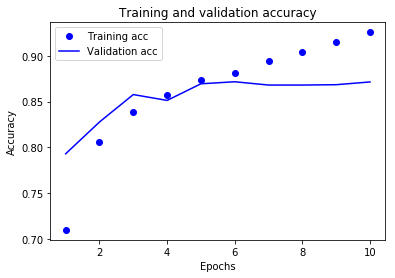

In [59]:
def plot_acc(history):
    import matplotlib.pyplot as plt
    history_dict = history.history
    acc_values = history_dict['acc']
    val_acc_values = history_dict['val_acc']
    
    epochs = range (1, len(acc_values) +1)


    plt.plot(epochs, acc_values, 'bo', label='Training acc')
    plt.plot(epochs, val_acc_values, 'b', label='Validation acc')

    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    return plt

plt_acc = plot_acc(history)
plt_acc.show()

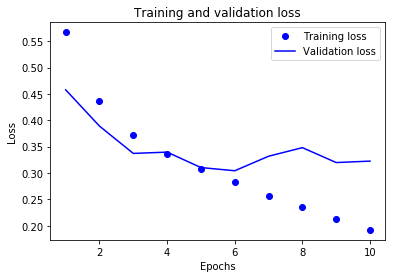

In [60]:
def plot_loss(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']

    epochs = range (1, len(loss_values) +1)

    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    return plt

plt = plot_loss(history)
plt.show()